In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

In [21]:
# Step 0: Load the data and split into sets
# Read the train.csv and test.csv files
train_data = pd.read_csv('sign_mnist_train.csv')#27455 images
test_data = pd.read_csv('sign_mnist_test.csv') #7172 images

# Extract the pixel values and labels from the train dataset
test_images = test_data.iloc[:, 1:].values.astype('float32')
test_labels = test_data.iloc[:, 0].values.astype('int32')
train_images = train_data.iloc[:, 1:].values.astype('float32')  # Exclude the label column
train_labels = train_data.iloc[:, 0].values.astype('int32')  # Extract the label column

# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Normalize the pixel values between 0 and 1
test_images /= 255.0
train_images /= 255.0
val_images /= 255.0

# Reshape the images to 28x28x1 (height, width, channels)
test_images = test_images.reshape(-1,28,28,1)
train_images = train_images.reshape(-1, 28, 28, 1)
val_images = val_images.reshape(-1, 28, 28, 1)

num_classes = 26



In [22]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

In [23]:
# Print the shapes of the datasets
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (21964, 28, 28, 1)
Train labels shape: (21964,)
Validation images shape: (5491, 28, 28, 1)
Validation labels shape: (5491,)
Test images shape: (7172, 28, 28, 1)
Test labels shape: (7172,)


In [24]:
# One-hot encode labels
train_labels = tf.one_hot(train_labels, num_classes)
val_labels = tf.one_hot(val_labels, num_classes)
test_labels = tf.one_hot(test_labels, num_classes)

In [25]:
# Step 2: Define the Model

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Batch normalization layer
batch_norm = tf.keras.layers.BatchNormalization()

# Model architecture
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    batch_norm,
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(26, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])




In [27]:
# Step 3: Train the Model


history = model.fit(datagen.flow(train_images, train_labels, batch_size=256),
                    validation_data=(val_images, val_labels),
                    epochs=20,
                    callbacks=[early_stopping],
                    verbose=1)




# Step 4: Save the Model

model.save('gesture_recognition_model.h5')

Epoch 1/20
86/86 [==============================] - 4s 41ms/step - loss: 1.3806 - accuracy: 0.5894 - val_loss: 2.6240 - val_accuracy: 0.5023
Epoch 2/20
86/86 [==============================] - 3s 40ms/step - loss: 0.4500 - accuracy: 0.8641 - val_loss: 1.9441 - val_accuracy: 0.9044
Epoch 3/20
86/86 [==============================] - 3s 40ms/step - loss: 0.2490 - accuracy: 0.9262 - val_loss: 1.2482 - val_accuracy: 0.9197
Epoch 4/20
86/86 [==============================] - 3s 39ms/step - loss: 0.1675 - accuracy: 0.9511 - val_loss: 0.6660 - val_accuracy: 0.9446
Epoch 5/20
86/86 [==============================] - 3s 39ms/step - loss: 0.1212 - accuracy: 0.9651 - val_loss: 0.2822 - val_accuracy: 0.9785
Epoch 6/20
86/86 [==============================] - 3s 40ms/step - loss: 0.1027 - accuracy: 0.9692 - val_loss: 0.1021 - val_accuracy: 0.9924
Epoch 7/20
86/86 [==============================] - 3s 40ms/step - loss: 0.0851 - accuracy: 0.9766 - val_loss: 0.0540 - val_accuracy: 0.9889
Epoch 8/20
86

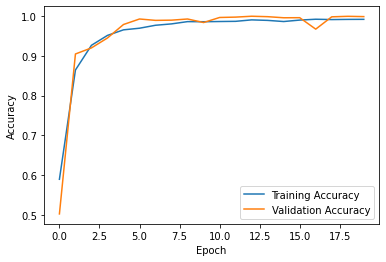

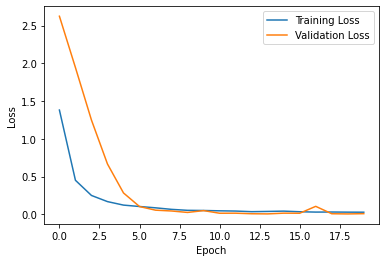

In [44]:
# Step 5: Plot Accuracy and Loss Curves

# Retrieve training accuracy and loss values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

# Plot loss curves
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('image_plot.png')
plt.show()

In [29]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

# Print the estimated accuracy
print("Estimated Accuracy:", test_accuracy)

225/225 - 0s - loss: 0.0417 - accuracy: 0.9833
Estimated Accuracy: 0.9832682609558105


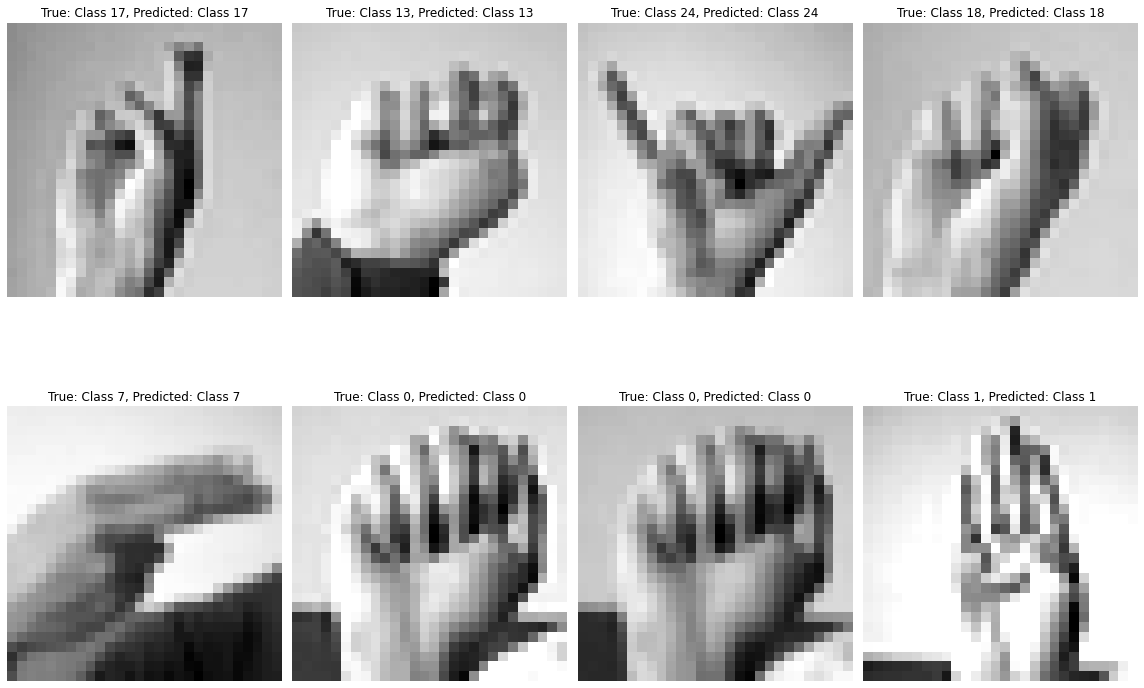

In [42]:

# Predict labels for test images
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Convert test_labels to numpy array and get the true labels as integers
test_labels = np.array(test_labels)
true_labels = np.argmax(test_labels, axis=1)

# Choose random images from the test set
random_indices = np.random.choice(len(test_images), size=8, replace=False)
selected_images = test_images[random_indices]
selected_true_labels = true_labels[random_indices]
selected_predicted_labels = predicted_labels[random_indices]

# Define a list of class labels (assuming 10 classes)
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12', 'Class 13', 'Class 14', 'Class 15', 'Class 16', 'Class 17', 'Class 18', 'Class 19', 'Class 20', 'Class 21', 'Class 22', 'Class 23', 'Class 24', 'Class 25']

# Plot the images along with their predicted labels
plt.figure(figsize=(16, 12))
for i, (image, true_label, predicted_label) in enumerate(zip(selected_images, selected_true_labels, selected_predicted_labels), 1):
    plt.subplot(2, 4, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('image.png')
plt.show()

<Figure size 432x288 with 0 Axes>